In [ ]:
pip install ortools matplotlib

Objetivo geral

Maximizar a utilização do espaço interno de um caminhão (volume cúbico), respeitando:

Peso máximo por eixo

Regras de empilhamento

Fragilidade e orientação da carga

Agrupamento por destino (para roteirização posterior)


---

1.1. Variáveis e parâmetros

Sejam:

: conjunto de itens a serem carregados

: conjunto de paletes disponíveis

: conjunto de blocos do caminhão (posição 3D discretizada)


---

▶ Parâmetros dos itens

Para cada item :

: dimensões (comprimento, largura, altura)

: volume

: massa

: é frágil?

: pode ser girado/orientado?

: destino



---

▶ Paletes e caminhão

Paletes têm capacidade máxima  (massa) e  (volume)

Caminhão tem espaço  (dimensões)

Discretizamos o caminhão em blocos cúbicos



---

1.2. Variáveis de decisão

: item  está no palete ?

: palete  está colocado na posição ?

: item  está diretamente no bloco ? (apenas se sem palete)

: orientação do item (6 possibilidades cúbicas)



---

1.3. Função objetivo

Maximizar o volume total carregado:

$$\max \sum_{i \in I} \sum_{p \in P} x_{i,p} \cdot v_i$$

ou, se quiser usar apenas o volume cúbico útil do caminhão:

$$\max \sum_{p \in P} \sum_{b \in B} y_{p,b} \cdot V_P$$


---

1.4. Restrições principais

🟩 1. Capacidade de massa da palete:

$$\sum_{i \in I} x_{i,p} \cdot m_i \leq M_P, \quad \forall p \in P$$

🟩 2. Capacidade volumétrica da palete:

$$\sum_{i \in I} x_{i,p} \cdot v_i \leq V_P, \quad \forall p \in P$$

🟩 3. Um item em apenas uma palete ou diretamente no caminhão:

$$\sum_{p \in P} x_{i,p} + \sum_{b \in B} z_{i,b} \leq 1, \quad \forall i \in I$$

🟩 4. Restrições de empilhamento:

Não empilhar item frágil

Item mais pesado não pode ficar sobre mais leve

$\text{Se } f_i = 1 \Rightarrow \text{não pode haver nenhum item sobre } i$

$\text{Se } i \text{ está sobre } j \Rightarrow m_i \leq m_j$

🟩 5. Restrições espaciais:

Itens não podem ultrapassar o volume do caminhão

Itens/paletes não podem se sobrepor

Coordenadas tridimensionais devem ser não colidentes

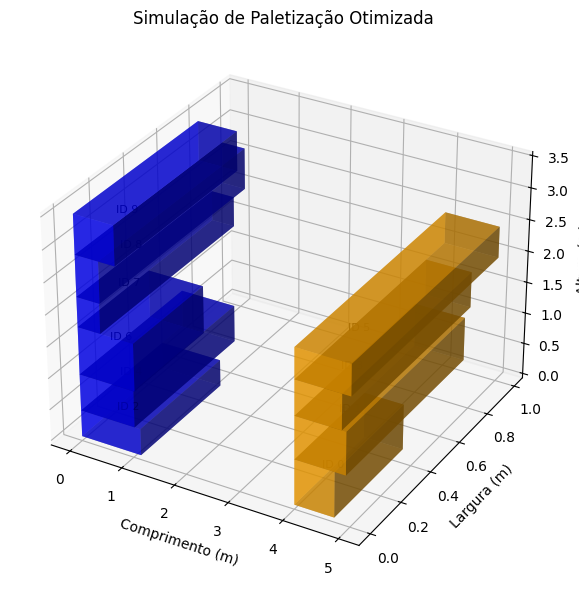

In [ ]:

from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# ----------- Parâmetros do caminhão e paletes -----------
CAMINHAO_L = 6.0  # metros
CAMINHAO_W = 2.5
CAMINHAO_H = 2.5
PALLET_CAP_MASS = 1000_000  # gramas (1 tonelada)
PALLET_CAP_VOL = 2_000_000  # cm³ (2 m³)
PALLET_QTD = 3

SCALE_VOL = 1_000_000  # m³ para cm³
SCALE_MASS = 1_000     # kg para g

# ----------- Geração de itens (simulação realista) -----------

def gerar_itens(n=10):
    itens = []
    for i in range(n):
        l = round(random.uniform(0.4, 1.2), 2)
        w = round(random.uniform(0.4, 1.0), 2)
        h = round(random.uniform(0.3, 0.8), 2)
        volume_m3 = l * w * h
        mass_kg = volume_m3 * random.uniform(200, 600)
        item = {
            'id': i,
            'l': l,
            'w': w,
            'h': h,
            'volume_cm3': int(volume_m3 * SCALE_VOL),
            'mass_g': int(mass_kg * SCALE_MASS),
            'f': random.choice([0, 1]),  # frágil
            'o': random.choice([0, 1]),  # orientável
            'd': random.randint(1, 2)    # destino
        }
        itens.append(item)
    return itens

itens = gerar_itens(10)
n = len(itens)

# ----------- Modelo de otimização com OR-Tools -----------

model = cp_model.CpModel()

# Variáveis: item i está na palete p?
x = {}
for i in range(n):
    for p in range(PALLET_QTD):
        x[i, p] = model.NewBoolVar(f'x_{i}_{p}')

# Restrição: cada item vai para no máximo uma palete
for i in range(n):
    model.Add(sum(x[i, p] for p in range(PALLET_QTD)) <= 1)

# Restrição: capacidade de massa e volume da palete
for p in range(PALLET_QTD):
    model.Add(
        sum(x[i, p] * itens[i]['mass_g'] for i in range(n)) <= PALLET_CAP_MASS
    )
    model.Add(
        sum(x[i, p] * itens[i]['volume_cm3'] for i in range(n)) <= PALLET_CAP_VOL
    )

# Função objetivo: maximizar volume total carregado
model.Maximize(
    sum(x[i, p] * itens[i]['volume_cm3'] for i in range(n) for p in range(PALLET_QTD))
)

# ----------- Solução -----------

solver = cp_model.CpSolver()
status = solver.Solve(model)

# ----------- Visualização 3D -----------

cargas_visualizadas = []

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    offset_x = 0
    cores = ['blue', 'green', 'orange']
    for p in range(PALLET_QTD):
        z_atual = 0
        for i in range(n):
            if solver.Value(x[i, p]):
                item = itens[i]
                cargas_visualizadas.append({
                    'x': offset_x,
                    'y': 0,
                    'z': z_atual,
                    'l': item['l'],
                    'w': item['w'],
                    'h': item['h'],
                    'cor': cores[p % len(cores)],
                    'id': item['id']
                })
                z_atual += item['h']
        offset_x += 2.0  # separação entre paletes

    # Plotagem 3D
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    for item in cargas_visualizadas:
        ax.bar3d(item['x'], item['y'], item['z'],
                 item['l'], item['w'], item['h'],
                 color=item['cor'], alpha=0.6)
        ax.text(item['x'] + item['l']/4,
                item['y'] + item['w']/4,
                item['z'] + item['h']/2,
                f"ID {item['id']}",
                color='black', fontsize=8)
    ax.set_xlabel("Comprimento (m)")
    ax.set_ylabel("Largura (m)")
    ax.set_zlabel("Altura (m)")
    ax.set_title("Simulação de Paletização Otimizada")
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma solução viável encontrada.")

# v2


Novas Regras

1. Empilhamento com fragilidade

Um item frágil não pode ter outro item acima dele.

Um item só pode ser empilhado sobre outro se ele for mais leve ou se o de baixo não for frágil.


---

2. Orientação dos itens

Se um item for rotacionável, ele pode ter até 6 combinações (permutações dos eixos: l, w, h).

Se não rotacionável, deve manter a orientação original.


---

🔢 Modelo Matemático (refatorado)

🔧 Novas variáveis

: orientação do item  no modo , ou uma simplificação binária com booleanos

: item  está sobre o item

: frágil?


---

🔒 Novas restrições

(R1) Respeitar fragilidade:

$$f_j = 1 \Rightarrow \sum_i a_{i,j} = 0$$

(R2) Item mais pesado só pode estar sobre item mais leve:

$$a_{i,j} = 1 \Rightarrow m_i \leq m_j$$

(R3) Orientação e rotação:

Para cada item rotacionável:

$$\sum_{k=1}^6 r_{i,k} = 1$$


---

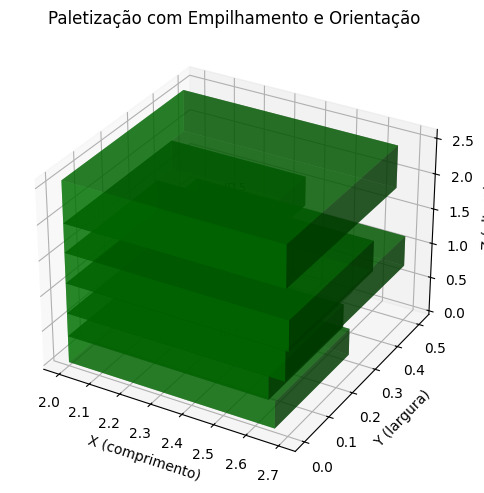

In [ ]:

from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np
import random

SCALE_VOL = 1_000_000  # m³ para cm³
SCALE_MASS = 1_000     # kg para g

PALLET_QTD = 2
PALLET_CAP_MASS = 1000_000
PALLET_CAP_VOL = 2_000_000

def gerar_itens(n=6, seed=42):
    random.seed(seed)
    itens = []
    for i in range(n):
        l = round(random.uniform(0.4, 0.8), 2)
        w = round(random.uniform(0.3, 0.6), 2)
        h = round(random.uniform(0.3, 0.6), 2)
        vol = l * w * h
        densidade = random.uniform(200, 500)
        mass = vol * densidade
        f = random.choice([0, 1])
        o = random.choice([0, 1])
        item = {
            'id': i,
            'l': l, 'w': w, 'h': h,
            'vol': int(vol * SCALE_VOL),
            'mass': int(mass * SCALE_MASS),
            'f': f,
            'o': o
        }
        itens.append(item)
    return itens

def permutacoes(l, w, h):
    return [
        (l, w, h), (l, h, w),
        (w, l, h), (w, h, l),
        (h, l, w), (h, w, l)
    ]

def otimizar(itens):
    model = cp_model.CpModel()
    n = len(itens)

    x = {}  # x[i,p]: item i está na palete p?
    r = {}  # r[i,k]: rotação k (até 6) usada?
    s = {}  # s[i,j]: item i empilhado sobre j

    for i in range(n):
        for p in range(PALLET_QTD):
            x[i, p] = model.NewBoolVar(f"x_{i}_{p}")
        for k in range(6):
            r[i, k] = model.NewBoolVar(f"r_{i}_{k}")
        for j in range(n):
            if i != j:
                s[i, j] = model.NewBoolVar(f"s_{i}_{j}")

    for i in range(n):
        # Cada item em uma única palete
        model.Add(sum(x[i, p] for p in range(PALLET_QTD)) <= 1)

        # Se rotacionável: soma das rotações == 1
        if itens[i]['o']:
            model.Add(sum(r[i, k] for k in range(6)) == 1)
        else:
            model.Add(r[i, 0] == 1)
            for k in range(1, 6):
                model.Add(r[i, k] == 0)

    # Fragilidade e empilhamento
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            # não pode empilhar sobre frágil
            if itens[j]['f']:
                model.Add(s[i, j] == 0)
            # peso restrito
            if itens[i]['mass'] > itens[j]['mass']:
                model.Add(s[i, j] == 0)

    # Capacidade da palete
    for p in range(PALLET_QTD):
        model.Add(
            sum(x[i, p] * itens[i]['mass'] for i in range(n)) <= PALLET_CAP_MASS
        )
        model.Add(
            sum(x[i, p] * itens[i]['vol'] for i in range(n)) <= PALLET_CAP_VOL
        )

    # Função objetivo: maximizar volume total carregado
    model.Maximize(
        sum(x[i, p] * itens[i]['vol'] for i in range(n) for p in range(PALLET_QTD))
    )

    # Resolver
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return solver, x, r, s
    else:
        return None, None, None, None

def visualizar(itens, solver, x, r):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    offset_x = 0
    colors = ['blue', 'green']
    for p in range(PALLET_QTD):
        z_top = 0
        for i in range(len(itens)):
            if solver.Value(x[i, p]) == 1:
                orient = [k for k in range(6) if solver.Value(r[i, k]) == 1][0]
                l, w, h = permutacoes(itens[i]['l'], itens[i]['w'], itens[i]['h'])[orient]
                ax.bar3d(offset_x, 0, z_top, l, w, h, alpha=0.6, color=colors[p])
                ax.text(offset_x + l/2, 0.2, z_top + h/2, f"ID {i}", fontsize=8)
                z_top += h
        offset_x += 2.0
    ax.set_xlabel("X (comprimento)")
    ax.set_ylabel("Y (largura)")
    ax.set_zlabel("Z (altura)")
    ax.set_title("Paletização com Empilhamento e Orientação")
    plt.tight_layout()
    plt.show()

# -------- Execução --------
itens = gerar_itens(6)
solver, x, r, s = otimizar(itens)
if solver:
    visualizar(itens, solver, x, r)
else:
    print("Nenhuma solução encontrada.")

## Aplicação em Streamlit

In [ ]:
!pip install streamlit plotly ortools pandas numpy pyngrok -q

In [ ]:
!ngrok config add-authtoken "1g8n0GSPhERC09CL3X9MHFzNko6_4xfmf8g6xNBFZDjYvSaiE"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(addr=8501)
print("Streamlit app disponível em:", public_url)

Streamlit app disponível em: NgrokTunnel: "https://c8b2e7ebdca2.ngrok-free.app" -> "http://localhost:8501"
